# SRCapsNet - FCN (MNIST)
![image](https://i.imgur.com/PYRDSDB.png)

In [1]:
import os, sys, time
import numpy as np
import scipy.ndimage, scipy.misc
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
slim = tf.contrib.slim

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"



def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        return data

def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []
    
    for i in range(1,6):
        data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
        if i==1:
            train_data = data_dic['data']
        else:
            train_data = np.vstack((train_data, data_dic['data']))
        train_labels += data_dic['labels']
    test_data_dic = unpickle(data_dir + "/test_batch")
    test_data = test_data_dic['data']
    test_labels = test_data_dic['labels']
    
    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, test_data, test_labels

data_dir = '/ideaHome/Dropbox/SJ/ML/Cifar10/Data/cifar-10-batches-py'
trImg, train_labels, teImg, test_labels = load_cifar10_data(data_dir)


print("Training data set : %3d, Test data Set : %3d" %(trImg.shape[0], teImg.shape[0]))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Training data set : 50000, Test data Set : 10000


# MNIST DATA

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def toLR(image, scale=2.):
    if len(image.shape)==4:
        num_sample = image.shape[0]
        images = np.zeros([image.shape[0], int(image.shape[1]/scale), int(image.shape[2]/scale), image.shape[3]])
        for i in range(num_sample):
            images[i,:,:,0] = scipy.misc.imresize(image[i,:,:,0], 1/scale,'bicubic')
        return images
    else:
        return scipy.misc.imresize(image, 1/scale, 'bicubic')
    

def Bicubic(image, scale=2):
    if len(image.shape)==4:
        bicImg = scipy.ndimage.interpolation.zoom(image, [1, scale, scale, 1], prefilter=False)
    else:
        bicImg = scipy.ndimage.interpolation.zoom(image, [scale,scale, 1], prefilter=False)
    return bicImg

def _phase_shift(I, r):
    # Helper function with main phase shift operation
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (-1, a, b, r, r))
    X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
    X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, b, a*r, r
    X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, a*r, b*r
    return tf.reshape(X, (-1, a*r, b*r, 1))

def PS(X, r, color=False):
  # Main OP that you can arbitrarily use in you tensorflow code
    if color:
        Xc = tf.split(X,3,3) #(3, 3, X)
        X = tf.concat([_phase_shift(x, r) for x in Xc], axis=3)
    else:
        X = _phase_shift(X, r)
    return X

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
    return squash_factor * unit_vector

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


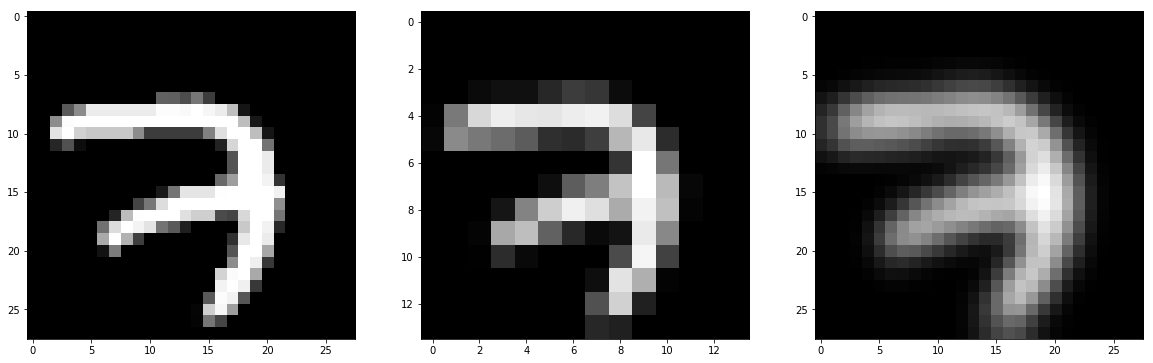

In [4]:
testSample = np.reshape(mnist.train.images[0,:], [1,28,28,1])

LRtestSample = toLR(testSample)

UPtestSample = Bicubic(LRtestSample, 2)
plt.figure(figsize=[20.,10])
plt.subplot(1,3,1)
plt.imshow(testSample[0,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(LRtestSample[0,:,:,0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(UPtestSample[0,:,:,0], cmap='gray')

In [5]:
class SRCapsNet(object):
    def __init__(self, mode):
        self.LR_dim = (28,28,1)
        self.HR_dim = (28,28,1)
        self.batch_size = 32
        self.mode = mode
        
        self.routing_iter = 2
        self.caps1_num = 6*6*32
        self.caps1_dim = 8
        self.caps2_vec = 10
        self.caps2_num = 1*1*self.caps2_vec
        self.caps2_dim = 16
        
        self.W_init = tf.random_normal(shape=(1, self.caps1_num, self.caps2_num, self.caps2_dim, self.caps1_dim), 
                                      stddev = 0.1, dtype=tf.float32, name='W_init')
        self.W = tf.Variable(self.W_init, name='w')
        
        print('The model is generated')
        
    def model(self, img):
        with slim.arg_scope([slim.conv2d],kernel_size=[9,9], stride=[1,1], activation_fn = tf.nn.leaky_relu,
                            padding='valid',weights_initializer=tf.contrib.layers.xavier_initializer()):
            
            self.conv1 = slim.conv2d(inputs=img, num_outputs=256, scope='conv1')
            print(self.conv1)
            self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=256, stride=[2,2], scope='conv2')
        batch_size = tf.shape(img)[0]    
        self.caps1 = tf.reshape(self.conv2, [batch_size, self.caps1_num, self.caps1_dim], name='caps1')
        self.caps1_squash = squash(self.caps1, name='caps1_squash')
            
            
        self.W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1], name='W_tiled')
            
        self.caps1_expanded = tf.expand_dims(self.caps1_squash, -1, name='caps1_expanded')
        self.caps1_expanded2 = tf.expand_dims(self.caps1_expanded, 2, name='caps1_expanded2')
        self.caps1_tiled = tf.tile(self.caps1_expanded2, [1, 1, self.caps2_num, 1, 1], name='caps1_tiled')
        self.caps2_in = tf.matmul(self.W_tiled, self.caps1_tiled, name='caps2_in')
        self.b_ij = tf.zeros([batch_size, self.caps1_num, self.caps2_num, 1, 1], name='b_ij')
        for i in range(self.routing_iter):
            if i>0:
                self.b_ij = tf.add(self.b_ij, agreement)
            self.c_ij = tf.nn.softmax(self.b_ij, dim=2, name='c_ij')
            self.s_j = tf.reduce_sum(tf.multiply(self.c_ij, self.caps2_in), axis=1, keep_dims=True, name='s_j')
            self.v_j = squash(self.s_j, axis=-2, name='v_j')
            if i<self.routing_iter-1:
                self.v_j_tiled = tf.tile(self.v_j, [1, self.caps1_num, 1, 1, 1], name='v_j_tiled')
                agreement = tf.matmul(self.caps2_in, self.v_j_tiled, transpose_a=True, name='agreement')

        self.caps2_out = self.v_j
        self.caps2_reshape = tf.reshape(self.caps2_out, [-1, 10*16], name='caps2_reshape')
        self.fc1 = slim.fully_connected(inputs=self.caps2_reshape, num_outputs=512, activation_fn=tf.nn.relu, scope='fc1')
        self.fc2 = slim.fully_connected(inputs=self.fc1, num_outputs=1024, activation_fn=tf.nn.relu, scope='fc2')
        self.fc3 = slim.fully_connected(inputs=self.fc2, num_outputs=784, activation_fn=tf.nn.sigmoid, scope='fc3')
        self.out_layer = tf.reshape(self.fc3, [-1, 28, 28, 1])
        #self.conv3 = slim.conv2d(inputs=self.caps2_reshape, num_outputs=12, scope='conv3', activation_fn=None)
        #self.out_layer = PS(self.conv3, 2, True)

        out = self.out_layer
        return out
    
    def loss(self, SR, HR):
        loss = tf.reduce_mean(tf.square(SR - HR), name='loss')
        return loss
    
    def build(self):
        if self.mode == 'bicubic':
            self.LRImg = tf.placeholder(tf.float32, [None, 28, 28, 1], 'LRImgBicubic')
        elif self.mode == 'pixelshuffle':
            self.LRImg = tf.placeholder(tf.float32, [None, 14, 14, 1], 'LRImgPixelShuffle')
        else:
            print ('undefined mode')
        self.HRImg = tf.placeholder(tf.float32, [None, 28, 28, 1], 'HRImg')
        self.SRImg = self.model(self.LRImg)
        self.LOSS = self.loss(self.SRImg, self.HRImg)
    
   
    
    

In [6]:
tf.reset_default_graph()
model = SRCapsNet('bicubic')
model.build()

t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The model is generated
Tensor("conv1/LeakyRelu/Maximum:0", shape=(?, 20, 20, 256), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
---------
Variables: name (type shape) [size]
---------
w:0 (float32_ref 1x1152x10x16x8) [1474560, bytes: 5898240]
conv1/weights:0 (float32_ref 9x9x1x256) [20736, bytes: 82944]
conv1/biases:0 (float32_ref 256) [256, bytes: 1024]
conv2/weights:0 (float32_ref 9x9x256x256) [5308416, bytes: 21233664]
conv2/biases:0 (float32_ref 256) [256, bytes: 1024]
fc1/weights:0 (float32_ref 160x512) [81920, bytes: 327680]
fc1/biases:0 (float32_ref 512) [512, bytes: 2048]
fc2/weights:0 (float32_ref 512x1024) [524288, bytes: 2097152]
fc2/biases:0 (float32_ref 1024) [1024, bytes: 4096]
fc3/weights:0 (float32_ref 1024x784) [802816, bytes: 3211264]
fc3/biases:0 (float32_ref 784) [784, bytes: 3136]
Total size of variables: 8215568
Total bytes of variables: 32862272


(8215568, 32862272)

In [7]:
optm = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(model.LOSS)

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
sess.run(tf.global_variables_initializer())
print('initialization complete')

initialization complete


In [14]:
batch_size=model.batch_size
print('batch_size: {}'.format(batch_size))
total_iter = mnist.train.num_examples // batch_size
for epoch in range(100):
    avg_psnr = 0
    start_time=time.time()
    for batch in range(total_iter):
        trImg, _= mnist.train.next_batch(batch_size)
        trImg = np.reshape(trImg, [-1, 28, 28, 1])
        LRImg = Bicubic(toLR(trImg))
        HRImg = trImg
        _, loss = sess.run([optm, model.LOSS], feed_dict={model.LRImg:LRImg, model.HRImg: HRImg})
        psnr = 20*np.log10(1./np.sqrt(loss))
        print ("\r batch: {}/{} ({:.1f}%) psnr: {:.5f}".format(
            batch, total_iter, batch*100/total_iter, psnr) ,end="")
        avg_psnr+=psnr
    print ('\repoch: %3d, avg_PSNR: %4f, tiem: %.2f' %(epoch, avg_psnr/total_iter, time.time()-start_time))

batch_size: 32


/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


epoch:   0, avg_PSNR: 23.977665, tiem: 378.13
 batch: 25/1718 (1.5%) psnr: 23.67023

KeyboardInterrupt: 

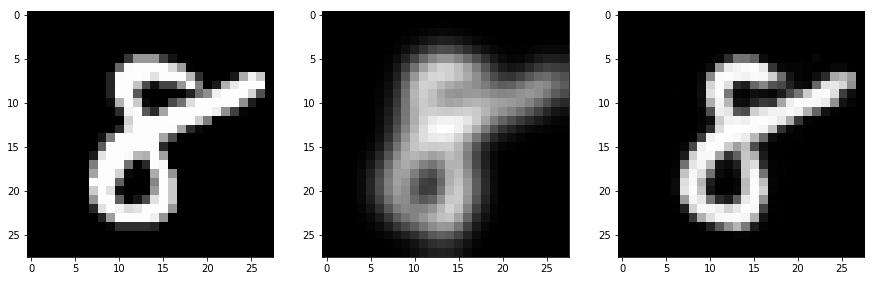

In [13]:
C=sess.run(model.out_layer, feed_dict={model.LRImg:LRImg})
plt.figure(figsize=[15,10])
plt.subplot(1,3,1)
plt.imshow(HRImg[0,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(LRImg[0,:,:,0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(C[0,:,:,0], cmap='gray')




In [12]:
np.max(A)

1.0

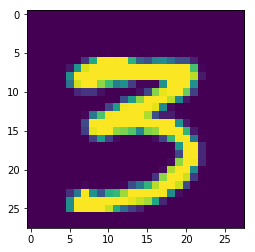

In [49]:
scipy.misc.imresize(A[0,:,:,0])